<a href="https://www.kaggle.com/code/rubanzasilva/s04e05-fastai?scriptVersionId=175699929" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


In [2]:
!pip install fastkaggle
!pip install optuna

In [37]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
#!pip install ucimlrepo
#from ucimlrepo import fetch_ucirepo

from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
#from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from xgboost import plot_importance

import lightgbm as lgb

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

from fastkaggle import setup_comp

import optuna

In [4]:
!ls /kaggle/input/playground-series-s4e5

sample_submission.csv  test.csv  train.csv


In [5]:
#set_seed(42)

In [6]:
path = Path('/kaggle/input/playground-series-s4e5/')
path

Path('/kaggle/input/playground-series-s4e5')

In [7]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')

In [8]:
train_df.head()

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,...,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
id,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,...,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,...,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,...,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,...,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,...,2,2,6,6,4,1,2,3,5,0.415


In [ ]:
train_df.shape

In [ ]:
train_df.columns

In [9]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='FloodProbability')
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)

X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

SuggestedLRs(slide=0.013182567432522774, valley=0.0006918309954926372)

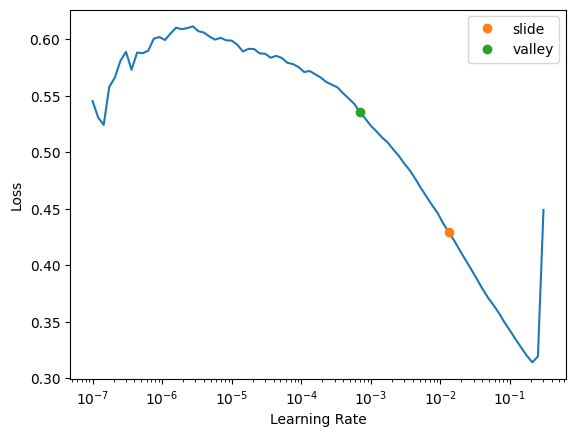

In [10]:
learn = tabular_learner(dls, metrics=R2Score())
learn.lr_find(suggest_funcs=(slide,valley))

In [ ]:
learn.fit_one_cycle(5,0.008)
dl = learn.dls.test_dl(test_df)
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)
nn_preds_z = a_preds.squeeze()

In [60]:
dl = learn.dls.test_dl(test_df)
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, b_preds = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)


AttributeError: 'NoneType' object has no attribute 'squeeze'

In [62]:
nn_preds_z = nn_preds_x.squeeze()
nn_preds_z.shape

torch.Size([223591])

In [24]:
r2_score(y_test,nn_preds_x)

0.8582930336968555

In [ ]:
def objective_catboost(trial):
    params = {
        "iterations": 200,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
    }
    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    cat_predictions = model.predict(X_test)
    r2score = r2_score(y_test, cat_predictions)
    return r2score

study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=100)
print(study_catboost.best_params)

In [25]:
print(study_catboost.best_params)

{'learning_rate': 0.010002778681585348, 'depth': 1, 'random_strength': 8}


In [41]:
#with optuna params
cat_model = CatBoostRegressor(iterations=500, depth=10, learning_rate=  0.25898169764803547, random_strength=8)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

0.8465353504876788

In [26]:
def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=30)
print(study_lgbm.best_params)

[I 2024-05-04 21:07:06,917] A new study created in memory with name: no-name-3fa726a6-a325-4cce-8678-abcf7bf906fe


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149435 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:07:24,904] Trial 0 finished with value: 0.2361711902401924 and parameters: {'num_leaves': 22, 'learning_rate': 0.011114213303778025, 'n_estimators': 124}. Best is trial 0 with value: 0.2361711902401924.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:07:46,940] Trial 1 finished with value: 0.5777587470524742 and parameters: {'num_leaves': 35, 'learning_rate': 0.029925016160683444, 'n_estimators': 149}. Best is trial 0 with value: 0.2361711902401924.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.154061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:08:14,057] Trial 2 finished with value: 0.6157599047600983 and parameters: {'num_leaves': 44, 'learning_rate': 0.02683704549995369, 'n_estimators': 178}. Best is trial 0 with value: 0.2361711902401924.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160761 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:08:37,558] Trial 3 finished with value: 0.7990860743791673 and parameters: {'num_leaves': 39, 'learning_rate': 0.07049817822029046, 'n_estimators': 167}. Best is trial 0 with value: 0.2361711902401924.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152958 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:08:54,827] Trial 4 finished with value: 0.28004103596147345 and parameters: {'num_leaves': 35, 'learning_rate': 0.01374562778025551, 'n_estimators': 107}. Best is trial 0 with value: 0.2361711902401924.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:09:14,847] Trial 5 finished with value: 0.8236513577121869 and parameters: {'num_leaves': 37, 'learning_rate': 0.20181797404434956, 'n_estimators': 183}. Best is trial 0 with value: 0.2361711902401924.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:09:33,050] Trial 6 finished with value: 0.5598937280366002 and parameters: {'num_leaves': 46, 'learning_rate': 0.03346407346339041, 'n_estimators': 116}. Best is trial 0 with value: 0.2361711902401924.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:09:56,314] Trial 7 finished with value: 0.3082905116316337 and parameters: {'num_leaves': 20, 'learning_rate': 0.011529836840367801, 'n_estimators': 173}. Best is trial 0 with value: 0.2361711902401924.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:10:20,501] Trial 8 finished with value: 0.5291839945959097 and parameters: {'num_leaves': 41, 'learning_rate': 0.022790801329815067, 'n_estimators': 158}. Best is trial 0 with value: 0.2361711902401924.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:10:45,143] Trial 9 finished with value: 0.8232503936295811 and parameters: {'num_leaves': 49, 'learning_rate': 0.08927059448017961, 'n_estimators': 171}. Best is trial 0 with value: 0.2361711902401924.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:10:58,825] Trial 10 finished with value: 0.8183289369467445 and parameters: {'num_leaves': 20, 'learning_rate': 0.28293777847070184, 'n_estimators': 133}. Best is trial 0 with value: 0.2361711902401924.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:11:14,831] Trial 11 finished with value: 0.20129764269865935 and parameters: {'num_leaves': 28, 'learning_rate': 0.010304173017857115, 'n_estimators': 102}. Best is trial 11 with value: 0.20129764269865935.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.149057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:11:33,408] Trial 12 finished with value: 0.23891288082644435 and parameters: {'num_leaves': 27, 'learning_rate': 0.010656153278781066, 'n_estimators': 123}. Best is trial 11 with value: 0.20129764269865935.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:11:48,634] Trial 13 finished with value: 0.3036089869196624 and parameters: {'num_leaves': 28, 'learning_rate': 0.017475829744469103, 'n_estimators': 100}. Best is trial 11 with value: 0.20129764269865935.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:12:15,119] Trial 14 finished with value: 0.7358929092062818 and parameters: {'num_leaves': 28, 'learning_rate': 0.043907761826204594, 'n_estimators': 199}. Best is trial 11 with value: 0.20129764269865935.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.157564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:12:33,766] Trial 15 finished with value: 0.3702031303500357 and parameters: {'num_leaves': 24, 'learning_rate': 0.018446893214263994, 'n_estimators': 130}. Best is trial 11 with value: 0.20129764269865935.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164683 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:12:52,699] Trial 16 finished with value: 0.7997505144530068 and parameters: {'num_leaves': 31, 'learning_rate': 0.08985408535653147, 'n_estimators': 142}. Best is trial 11 with value: 0.20129764269865935.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:13:09,466] Trial 17 finished with value: 0.20825835961116768 and parameters: {'num_leaves': 23, 'learning_rate': 0.010226446773882146, 'n_estimators': 114}. Best is trial 11 with value: 0.20129764269865935.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.159125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:13:26,936] Trial 18 finished with value: 0.32910645932765226 and parameters: {'num_leaves': 32, 'learning_rate': 0.016637146566731632, 'n_estimators': 112}. Best is trial 11 with value: 0.20129764269865935.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:13:41,718] Trial 19 finished with value: 0.5880049801904269 and parameters: {'num_leaves': 25, 'learning_rate': 0.047387430060955096, 'n_estimators': 108}. Best is trial 11 with value: 0.20129764269865935.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:13:55,250] Trial 20 finished with value: 0.8162069029515266 and parameters: {'num_leaves': 31, 'learning_rate': 0.16875679963597687, 'n_estimators': 100}. Best is trial 11 with value: 0.20129764269865935.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165748 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:14:13,232] Trial 21 finished with value: 0.22035478242246065 and parameters: {'num_leaves': 23, 'learning_rate': 0.010139642578980796, 'n_estimators': 123}. Best is trial 11 with value: 0.20129764269865935.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.153460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:14:33,568] Trial 22 finished with value: 0.240793114750398 and parameters: {'num_leaves': 24, 'learning_rate': 0.010020748260270697, 'n_estimators': 137}. Best is trial 11 with value: 0.20129764269865935.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.158771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:14:51,210] Trial 23 finished with value: 0.2979226323729859 and parameters: {'num_leaves': 26, 'learning_rate': 0.014692829397202437, 'n_estimators': 119}. Best is trial 11 with value: 0.20129764269865935.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.198199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:15:09,090] Trial 24 finished with value: 0.4129629721545597 and parameters: {'num_leaves': 23, 'learning_rate': 0.02242510351111253, 'n_estimators': 127}. Best is trial 11 with value: 0.20129764269865935.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:15:26,302] Trial 25 finished with value: 0.2752381632661348 and parameters: {'num_leaves': 29, 'learning_rate': 0.013612711361212164, 'n_estimators': 112}. Best is trial 11 with value: 0.20129764269865935.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.152246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:15:45,102] Trial 26 finished with value: 0.41134204360397153 and parameters: {'num_leaves': 21, 'learning_rate': 0.020692019512867133, 'n_estimators': 141}. Best is trial 11 with value: 0.20129764269865935.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.167429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:16:01,868] Trial 27 finished with value: 0.2666945369866188 and parameters: {'num_leaves': 32, 'learning_rate': 0.013528358095082592, 'n_estimators': 105}. Best is trial 11 with value: 0.20129764269865935.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.156030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:16:18,097] Trial 28 finished with value: 0.5694599319642388 and parameters: {'num_leaves': 26, 'learning_rate': 0.03980481592377294, 'n_estimators': 119}. Best is trial 11 with value: 0.20129764269865935.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.162569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


[I 2024-05-04 21:16:35,806] Trial 29 finished with value: 0.2562666596965886 and parameters: {'num_leaves': 22, 'learning_rate': 0.012482380937486872, 'n_estimators': 122}. Best is trial 11 with value: 0.20129764269865935.


{'num_leaves': 28, 'learning_rate': 0.010304173017857115, 'n_estimators': 102}


In [43]:
lgb_model = lgb.LGBMRegressor(num_leaves=47, learning_rate=0.19470589857022183, n_estimators=165)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))


r2_score(y_test,lgb_preds_x)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.151782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 894366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504502


0.8240061955381228

In [27]:
def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    xgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, xgb_predictions)
    return r2score


study_xgboost = optuna.create_study(direction='minimize')
study_xgboost.optimize(objective_xgboost, n_trials=30)
print(study_xgboost.best_params)

[I 2024-05-04 21:18:15,604] A new study created in memory with name: no-name-dff87500-9bd3-4f71-95de-acf1b48828c7
[I 2024-05-04 21:18:23,576] Trial 0 finished with value: 0.5180051214112821 and parameters: {'n_estimators': 131, 'max_depth': 2, 'learning_rate': 0.07900599905806904, 'subsample': 0.9733644558119448}. Best is trial 0 with value: 0.5180051214112821.
[I 2024-05-04 21:18:34,280] Trial 1 finished with value: 0.4618389115838998 and parameters: {'n_estimators': 170, 'max_depth': 2, 'learning_rate': 0.04811513683499964, 'subsample': 0.12714024405178484}. Best is trial 1 with value: 0.4618389115838998.
[I 2024-05-04 21:19:04,403] Trial 2 finished with value: 0.5618573736653004 and parameters: {'n_estimators': 193, 'max_depth': 8, 'learning_rate': 0.014225050269531608, 'subsample': 0.1690575075738766}. Best is trial 1 with value: 0.4618389115838998.
[I 2024-05-04 21:19:24,851] Trial 3 finished with value: 0.8200504064098856 and parameters: {'n_estimators': 172, 'max_depth': 8, 'lea

{'n_estimators': 113, 'max_depth': 1, 'learning_rate': 0.03445820915325066, 'subsample': 0.7878316073458079}


In [44]:
xgb_model = xgb.XGBRegressor(n_estimators = 187, max_depth=8, learning_rate=0.046018206875864616, subsample=0.7091172175235119)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

r2_score(y_test,xgb_preds_x)

0.7819594710440736

In [39]:
rf = RandomForestRegressor(20, min_samples_leaf=5)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

r2_score(y_test,rf_preds_x)

KeyboardInterrupt: 

In [63]:
general_preds = (lgb_preds_x + xgb_preds_x + cat_preds_x + nn_preds_z)/4
general_preds

tensor([0.4986, 0.4469, 0.4584,  ..., 0.5271, 0.4555, 0.4695])

In [65]:
general_preds = (lgb_preds + xgb_preds + cat_preds + nn_preds_y)/4               
general_preds

tensor([0.5722, 0.4536, 0.4609,  ..., 0.6128, 0.5480, 0.5146])

In [56]:
lgb_preds_x.shape,xgb_preds_x.shape,cat_preds_x.shape,nn_preds_x.shape                     

(torch.Size([223591]),
 torch.Size([223591]),
 torch.Size([223591]),
 torch.Size([223591, 1]))

In [57]:
a_preds.shape

torch.Size([745305, 1])

In [49]:
lgb_preds.shape,xgb_preds.shape,cat_preds.shape,nn_preds_y.shape             
              

(torch.Size([745305]),
 torch.Size([745305]),
 torch.Size([745305]),
 torch.Size([745305]))

In [45]:
y_test.shape,X_train.shape

((223591,), (894366, 20))

In [46]:
nn_preds_y.shape,nn_preds_x.shape    

(torch.Size([745305]), torch.Size([223591, 1]))

In [ ]:
r2_score(y_test,general_preds)

In [66]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = general_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [67]:
!ls

catboost_info  models  submission.csv


In [ ]:
general_preds = (lgb_preds + xgb_preds + cat_preds)

In [ ]:
general_preds